# Titanic - Machine Learning from Disaster

The Titanic ML competition is typically the first challenge beginners complete on the Kaggle platform. The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## 1. Imports

In [289]:
# Data tools
import pandas as pd
import numpy as np
from collections import Counter

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Machine Learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Model evaluation
from sklearn.model_selection import cross_val_score

## 2. Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

First we can preview the datasets to see what they consist of.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
print('Training set shape: ', train.shape)
print('Test set shape: ', test.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)


The 'Survived' column is missing in the test DataFrame because that is our target variable. Our goal is to analyze the training set and predict the survival of the passengers in the test set.

And now the sample submission:

In [9]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [10]:
gender_submission.shape

(418, 2)

## 3. Data Overview

The data has been split into two groups by Kaggle:

- training set (train.csv)
- test set (test.csv)

The training set will be used to build the models.

The test set will measure how well the model performs on unseen data.

The ```gender_submission.csv``` file is a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

| Variable      | Definition | Key |
| :---        | :---        | :---        |
| survival    | Survival    | 0 = No, 1 = Yes |
| pclass      | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex    | Sex    |   |
| Age    | Age    |   |
| sibsp    | # of siblings / spouses aboard the Titanic    |   |
| parch    | # of parents / children aboard the Titanic    |   |
| ticket    | Ticket number    |   |
| fare    | Passenger fare    |   |
| cabin    | Cabin number    |   |
| embarked    | Port of Embarkation    | C = Cherbourg, Q = Queenstown, S = Southampton  |

## 4. Exploratory Data Analysis (EDA)

EDA is the process of visualizing and analyzing data to derive insights. We can also look at data types, missing data and summary statistics.

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The train dataset has many complete rows, but some are missing a few values, like Age, Cabin, and Embarked.

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [30]:
# Missing data in training set by columns

train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [31]:
# Missing data in test set by columns

test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

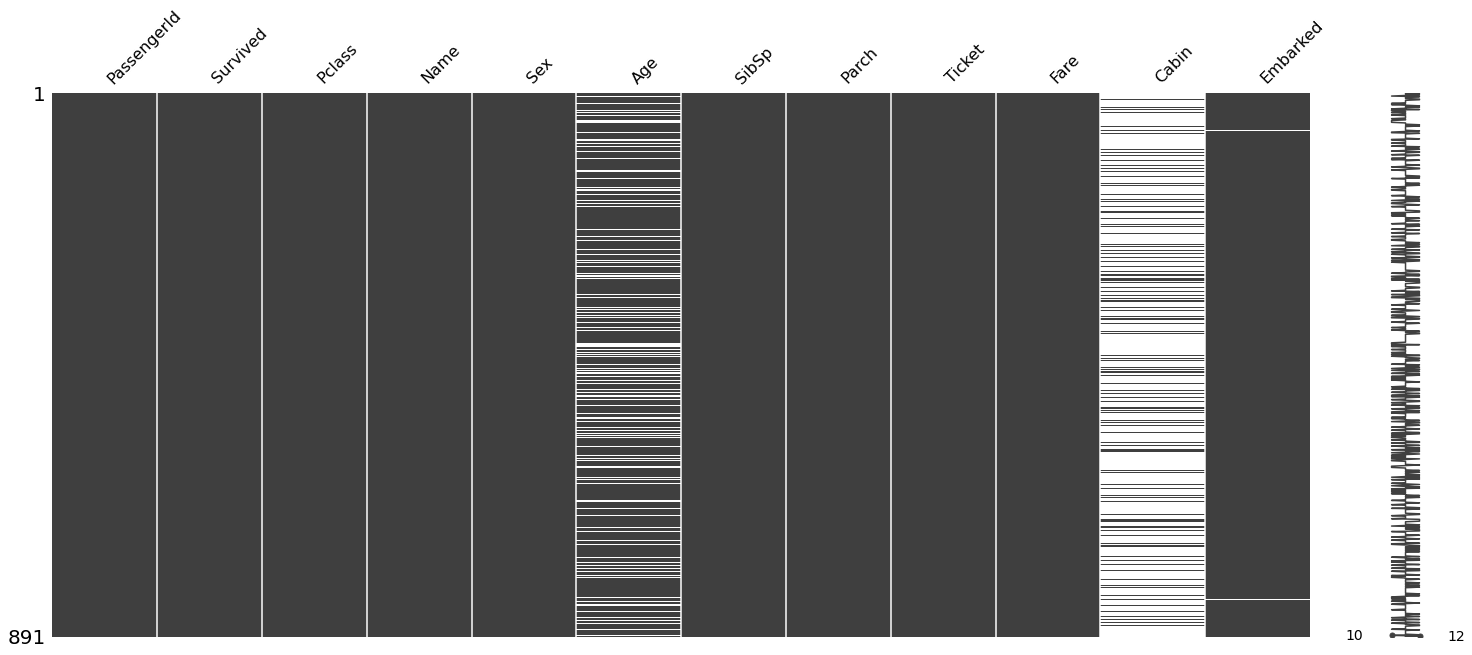

In [37]:
# Missing data in the train set can be visualized with the Missingno package
# - https://pypi.org/project/missingno/

missingno.matrix(train);

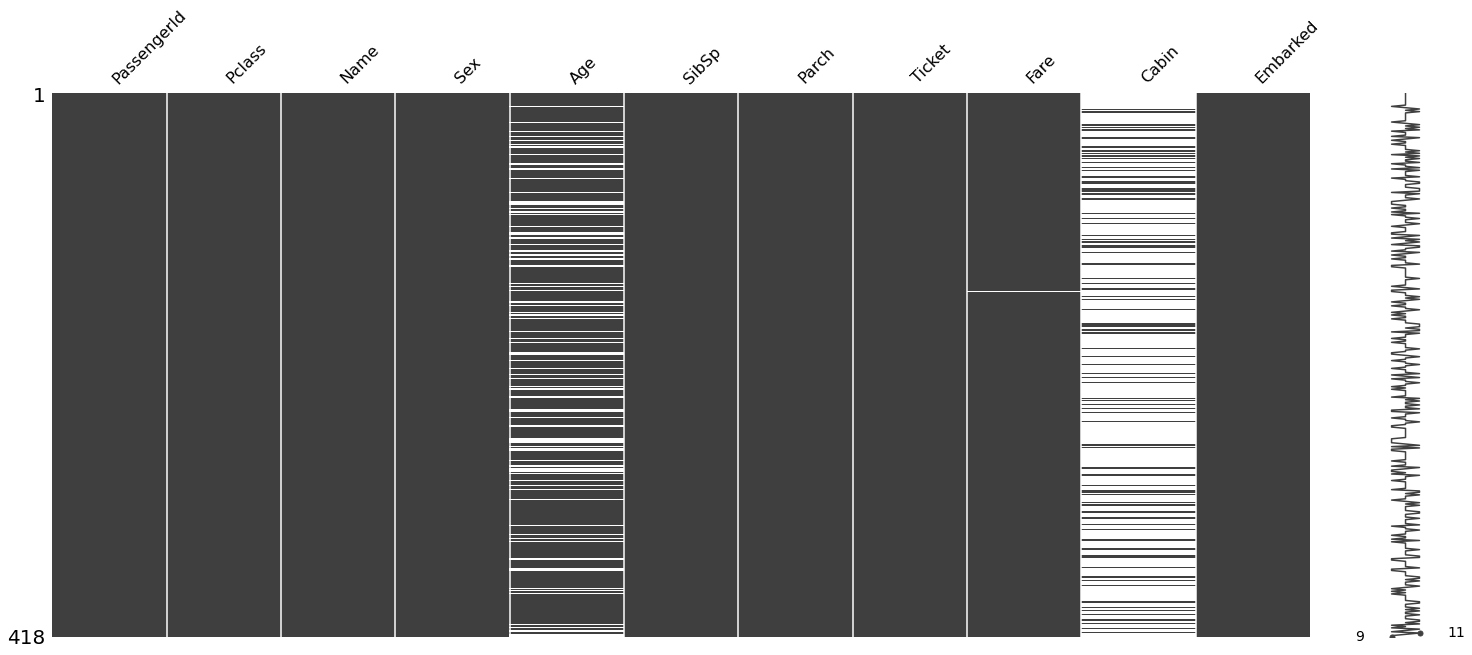

In [39]:
# Missing data in the test set, visualized

missingno.matrix(test);

In [42]:
# summary statistics for the training set

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [41]:
# summary statistics for the test set

test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### Survival Rate by Sex

In [44]:
# Check value counts on Sex

train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [55]:
# Calculate the average survival rate by Sex

train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


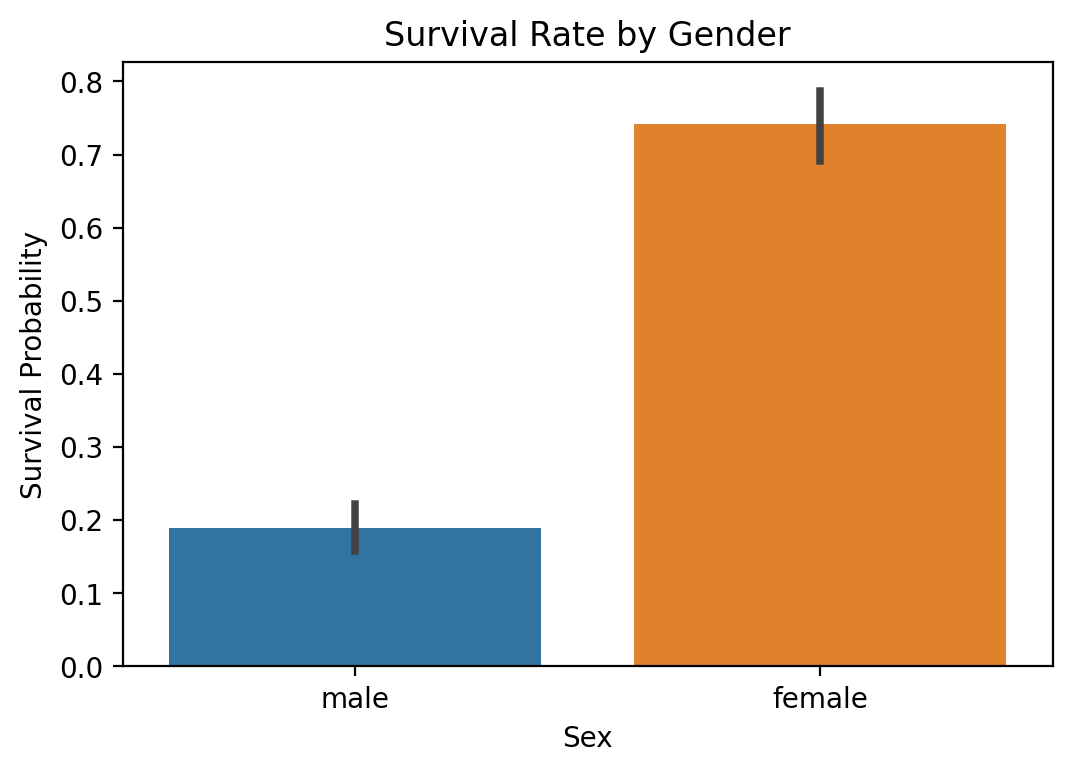

In [62]:
fig = plt.figure(dpi=200)
sns.barplot(x = 'Sex', y = 'Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by Gender')
plt.show()

### Survival Rate by Passenger Class

In [72]:
# Calculate value counts on Passenger Class

train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [74]:
# Calculate the average survival rate by Passenger Class

train[['Pclass', 'Survived']].groupby('Pclass', as_index = False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


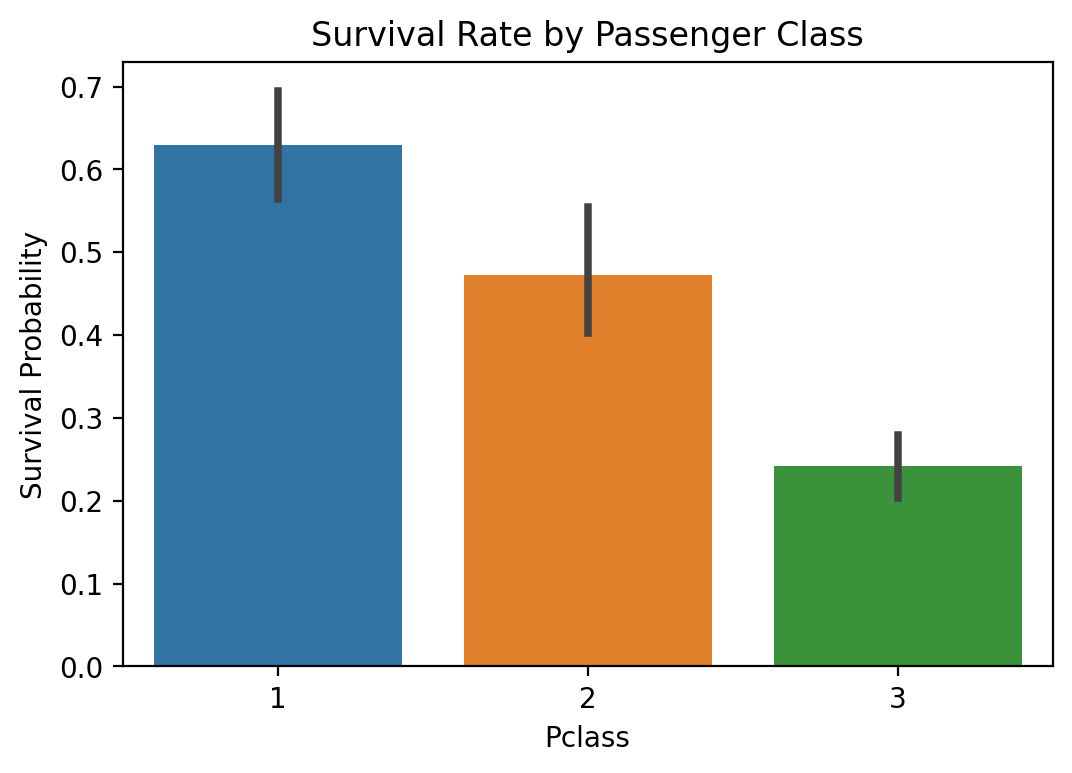

In [75]:
fig = plt.figure(dpi=200)
sns.barplot(x = 'Pclass', y = 'Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by Passenger Class')
plt.show()

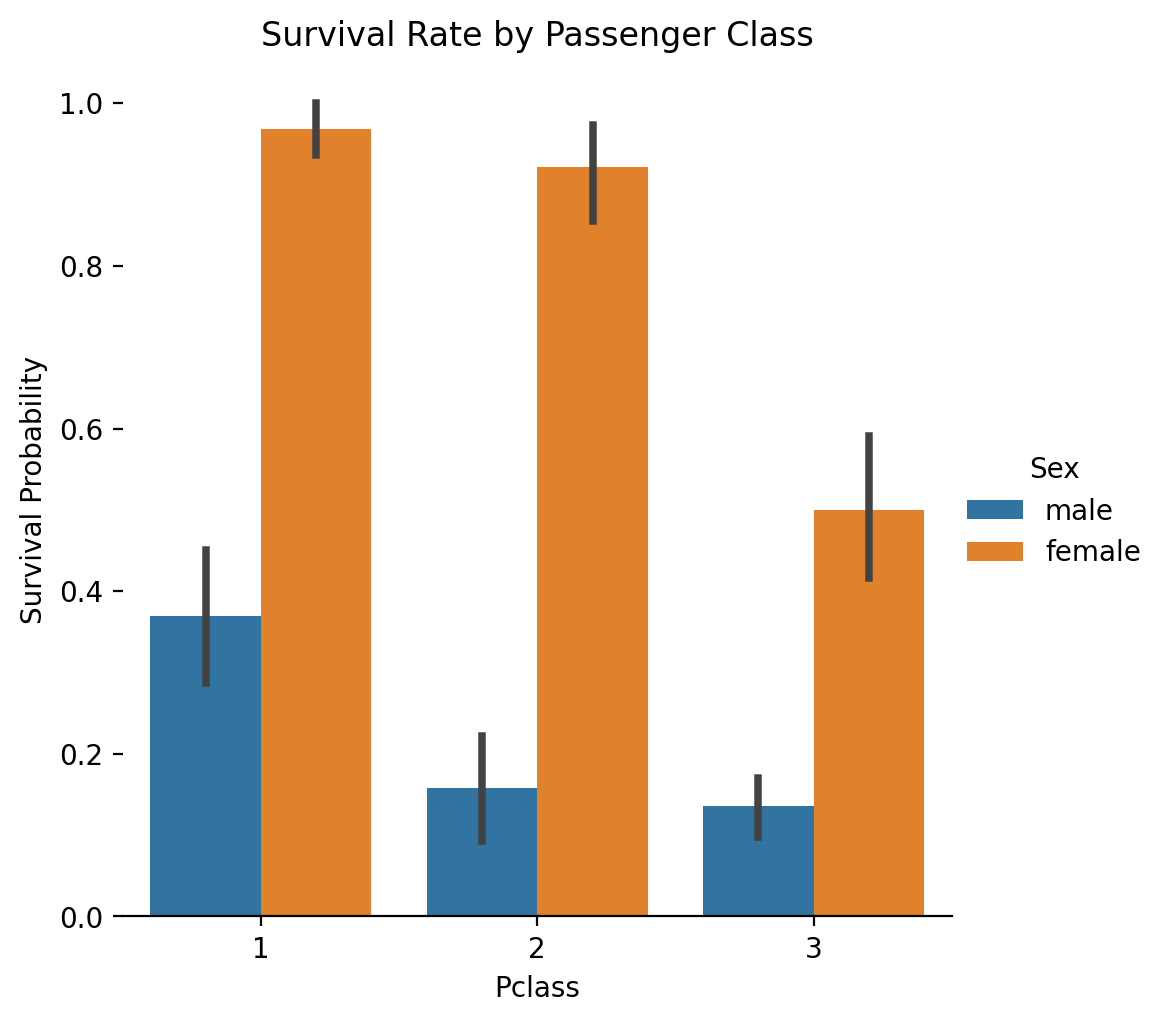

In [88]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data = train, kind='bar', hue='Sex')
g.despine(left=True)
g.fig.set_dpi(200)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by Passenger Class')
plt.show()

In [100]:
# Calculate value counts for Embarked

train['Embarked'].value_counts(dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [101]:
# Survival rates by Embarked

train[['Embarked', 'Survived']].groupby('Embarked', as_index = False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


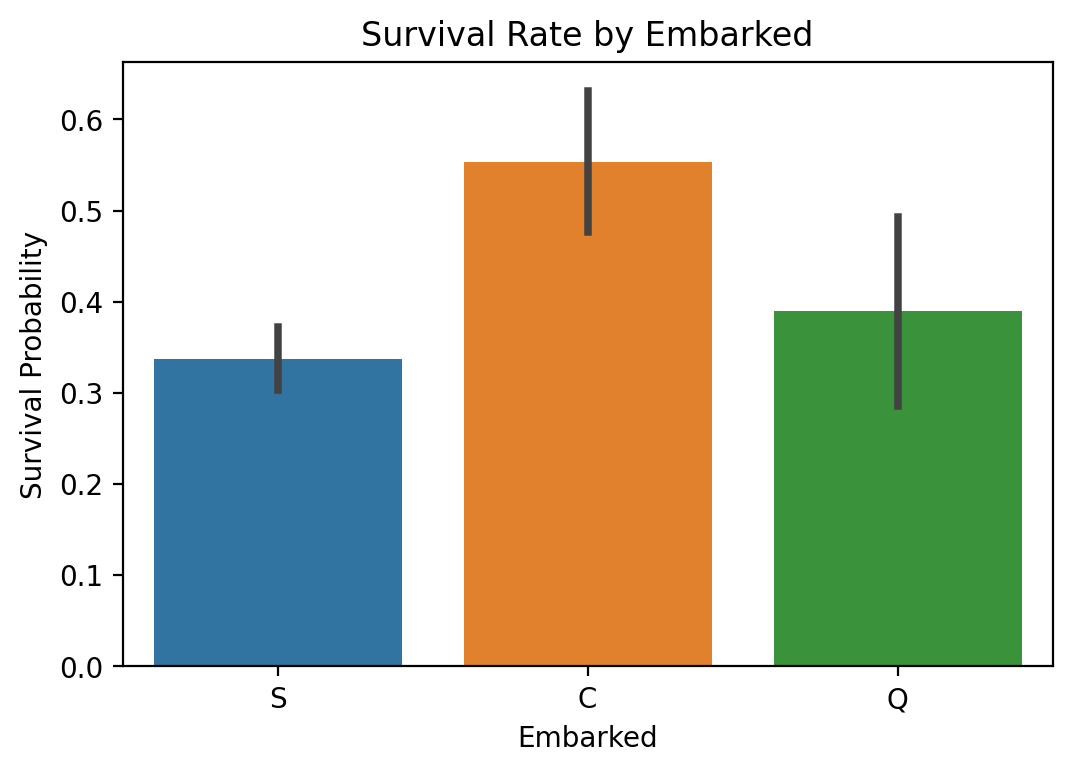

In [102]:
fig = plt.figure(dpi=200)
sns.barplot(x = 'Embarked', y = 'Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by Embarked')
plt.show()

It would appear strange that the point of departure would affect survival rates but this was more likely due to where first class passengers were originating from.

We can break down which point of embarkation each passenger class came from.

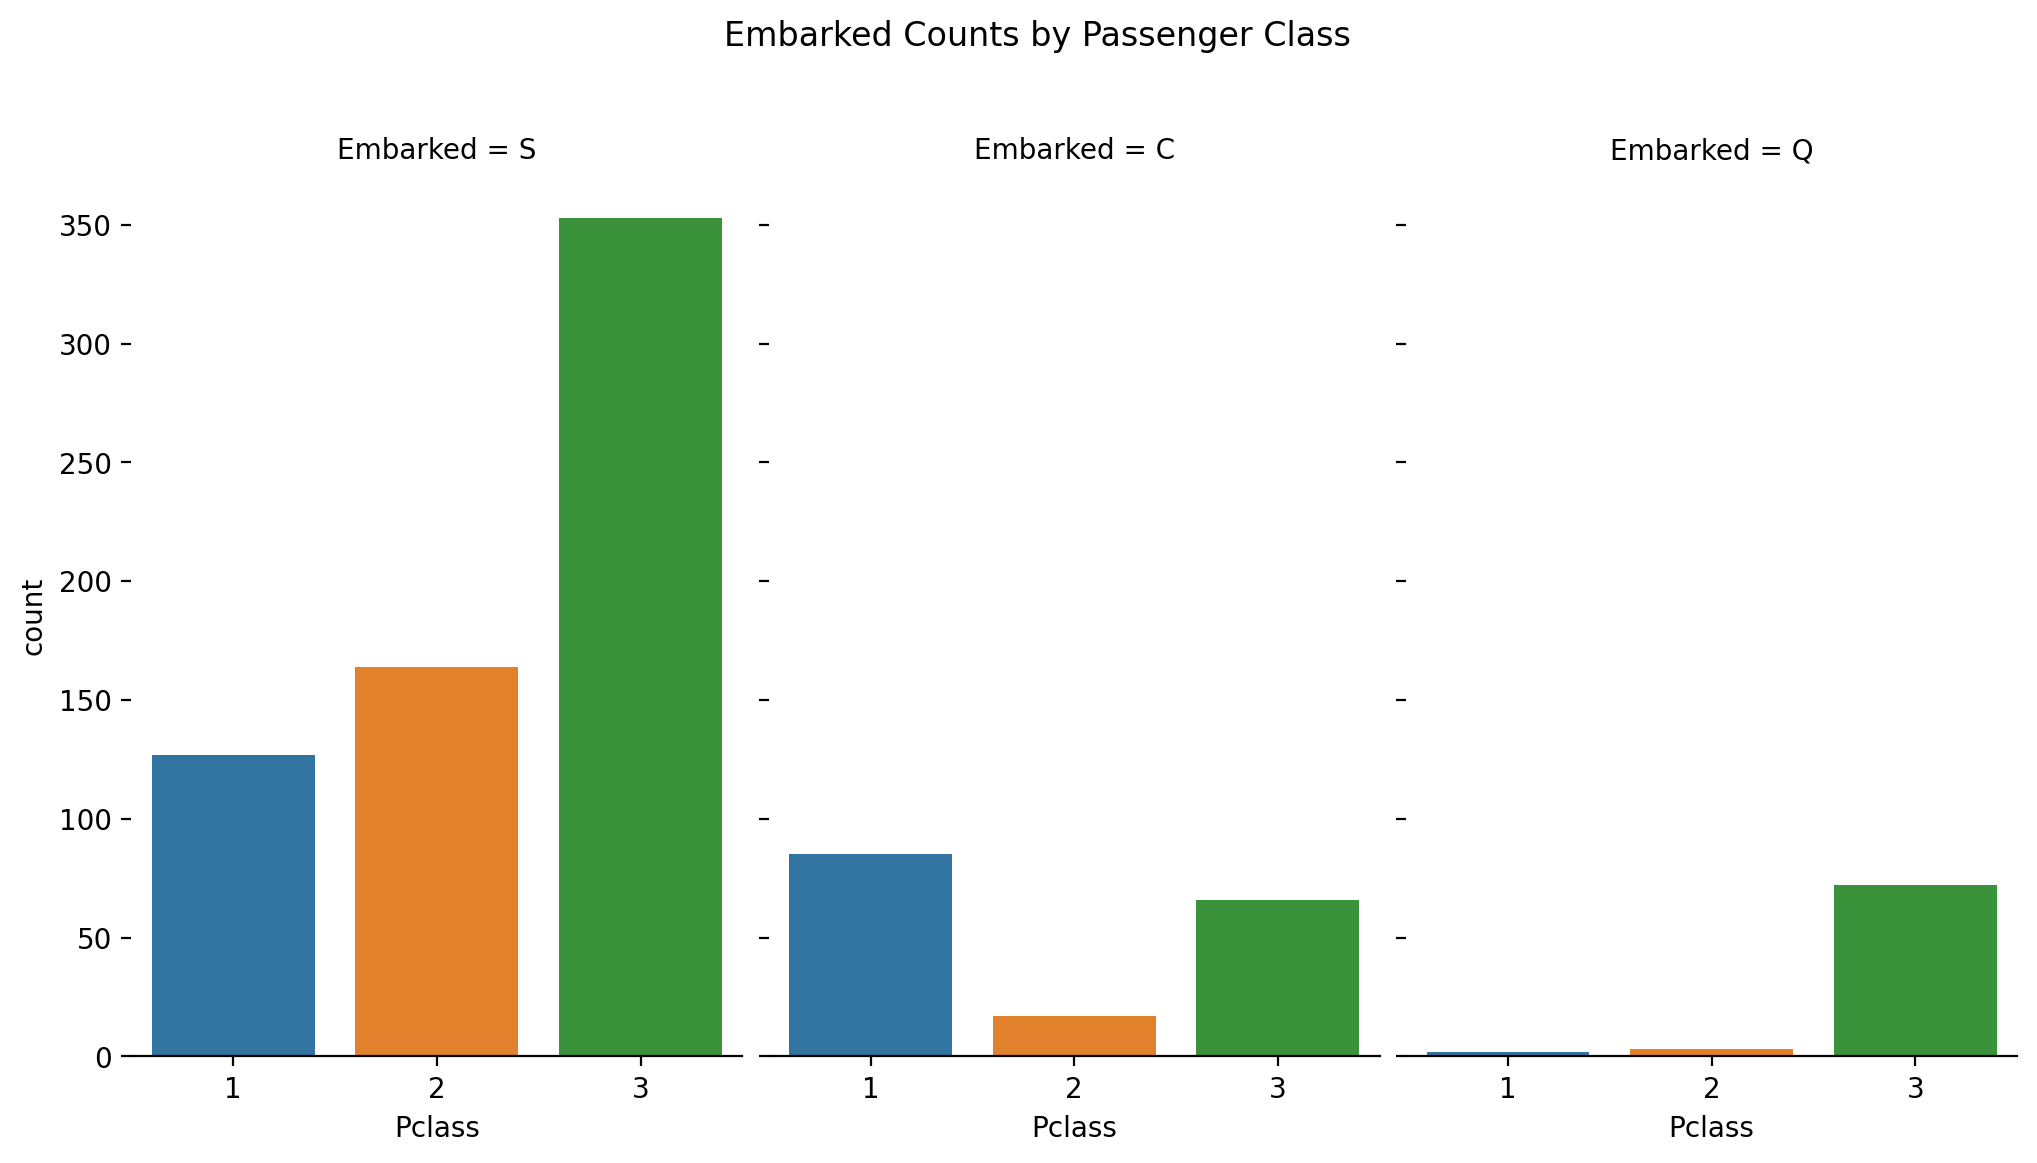

In [124]:
g = sns.catplot(x='Pclass', col='Embarked', data = train, kind='count')
g.despine(left=True)
g.fig.set_dpi(200)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Embarked Counts by Passenger Class')
g.fig.subplots_adjust(top=0.85)
plt.show()

The Cherbourg port had the highest ratio of first-class passengers to we can conclude that C would also have the highest survival rates.

### Numerical Values

The numerical values in the data are SibSp, Parch, Age, and Fare.

We should detect outliers in the numerical data. These can affect the accuracy of model predictions.

In [131]:
def detect_outliers(df, n, features):
    """"
    This function will loop through a list of features and detect outliers in each one of those features. In each
    loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds
    third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the 
    outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next
    feature and the process repeats until the very last feature is completed. Finally, using the list with outlier 
    indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.    
    
    Based on the Tukey method
    """
    
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return multiple_outliers

outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

train.loc[outliers_to_drop, :]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [132]:
# drop the outliers

print("Before drop: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After drop: {} rows".format(len(train)))

Before drop: 891 rows
After drop: 881 rows


### Correlation between Numerical Variables and Survival

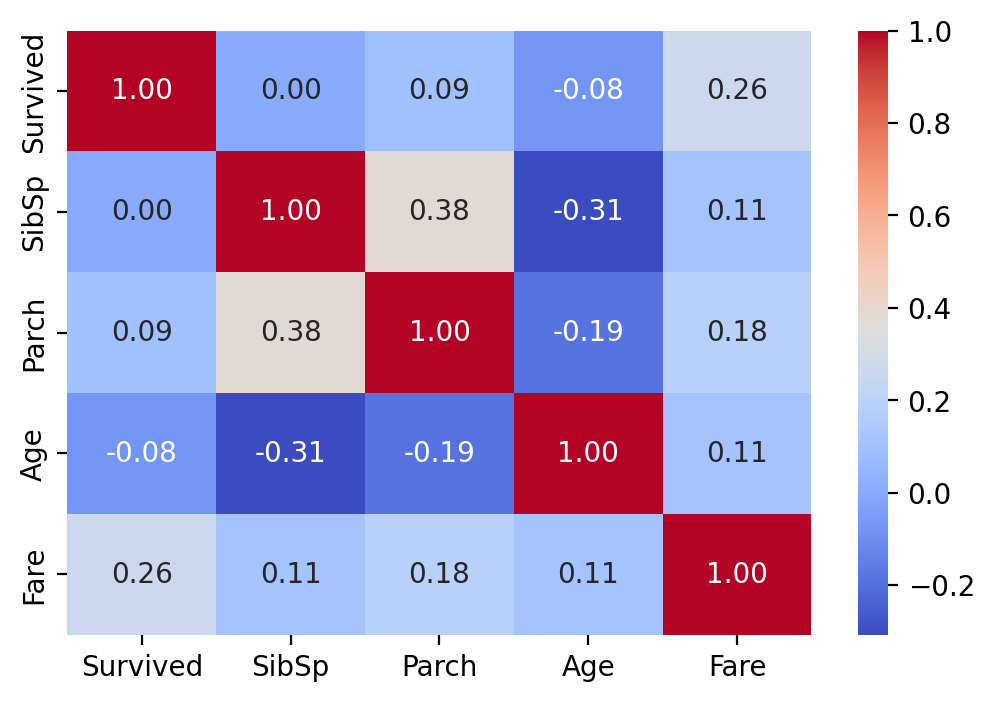

In [138]:
fig = plt.figure(dpi=200)
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

The Fare and Parch seems to be the only features with significant correlation with survivial. This makes sense becaue first-class passengers would have paid a higher fare than others. And those with parents (like kids) would have aligned with "women and children first".

### SibSp Variable

In [140]:
# Calculate counts of SibSp

train['SibSp'].value_counts(dropna=False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [142]:
# Calculate average survival rate by SibSp

train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


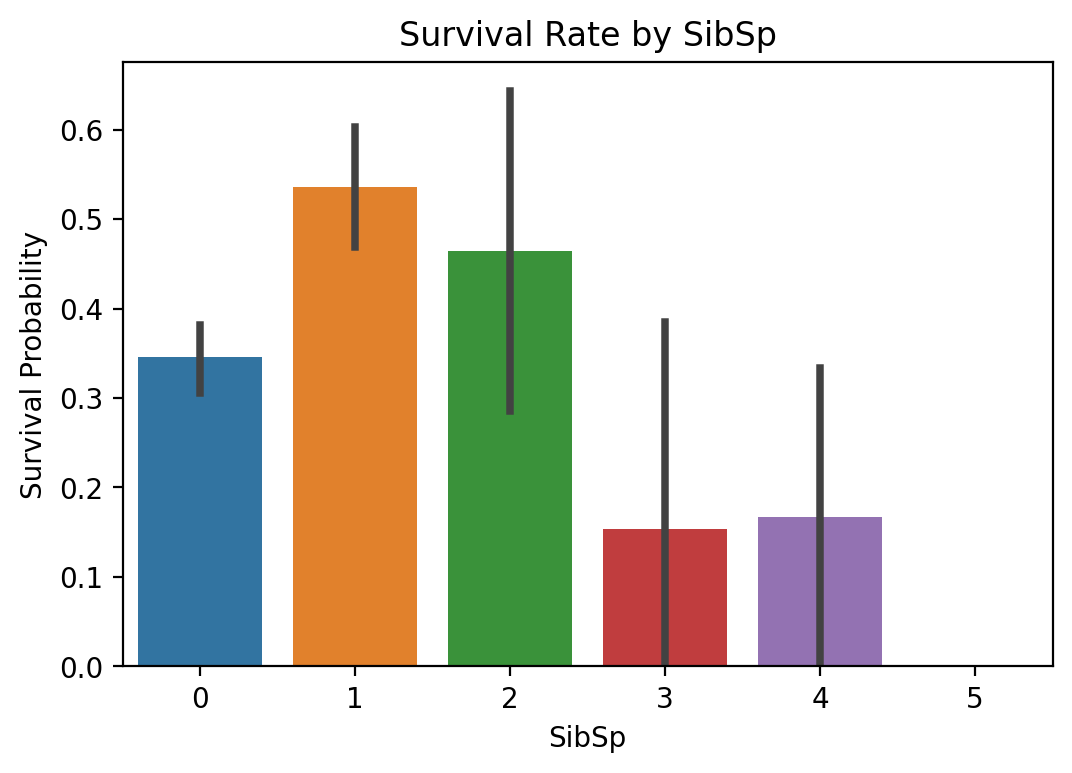

In [143]:
fig = plt.figure(dpi=200)
sns.barplot(x = 'SibSp', y = 'Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by SibSp')
plt.show()

### Parch Variable

In [144]:
# Calculate counts of Parch

train['Parch'].value_counts(dropna=False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [145]:
# Calculate average survival rate by Parch

train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


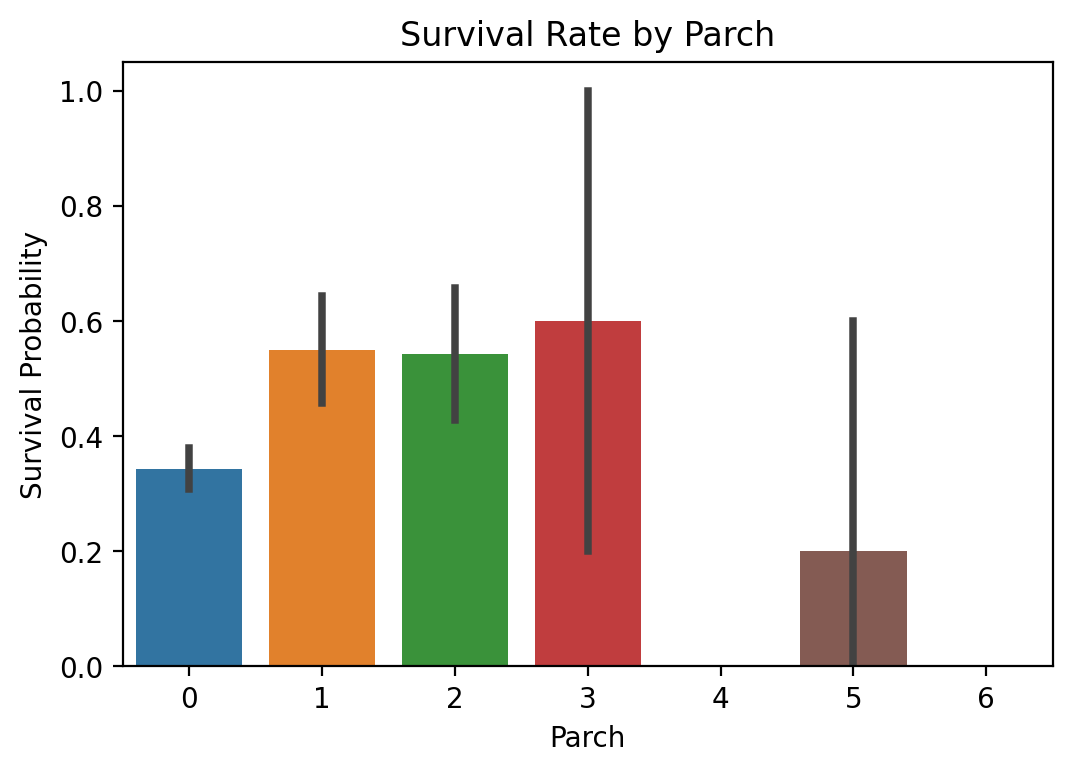

In [146]:
fig = plt.figure(dpi=200)
sns.barplot(x = 'Parch', y = 'Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Rate by Parch')
plt.show()

### Age Variable

In [147]:
# determine number of null values

train['Age'].isnull().sum()

170

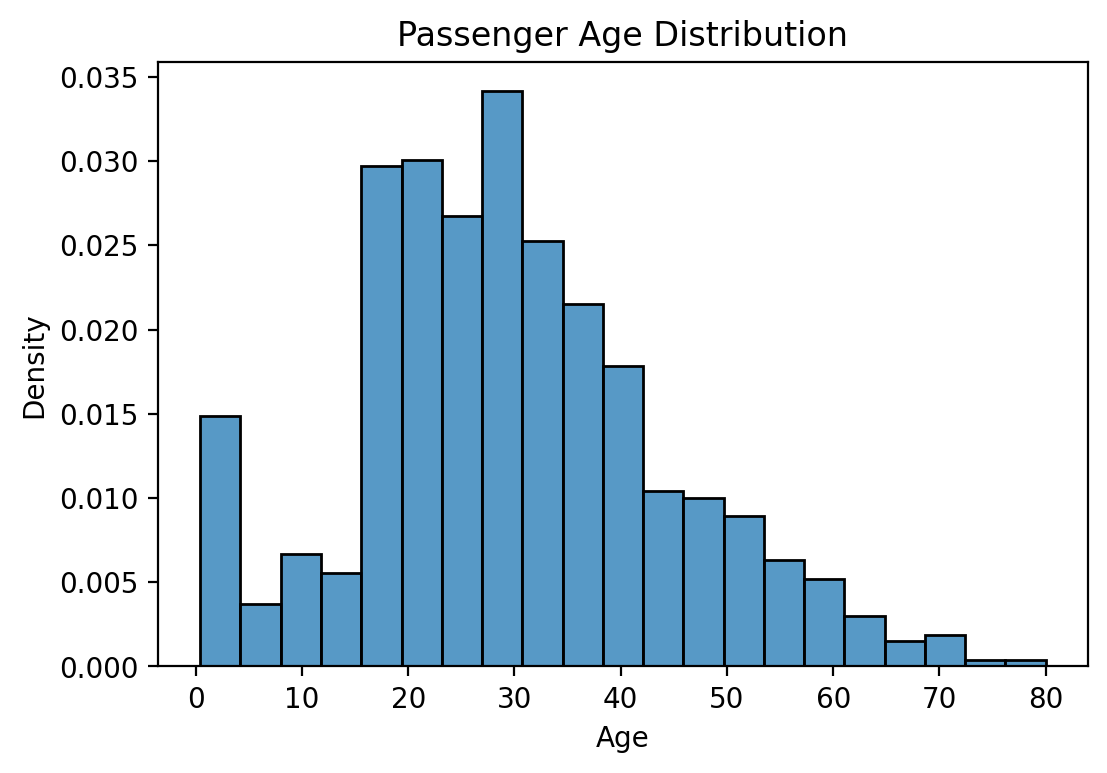

In [158]:
fig = plt.figure(dpi=200)
sns.histplot(train['Age'], stat='density')
plt.title('Passenger Age Distribution')
plt.show()

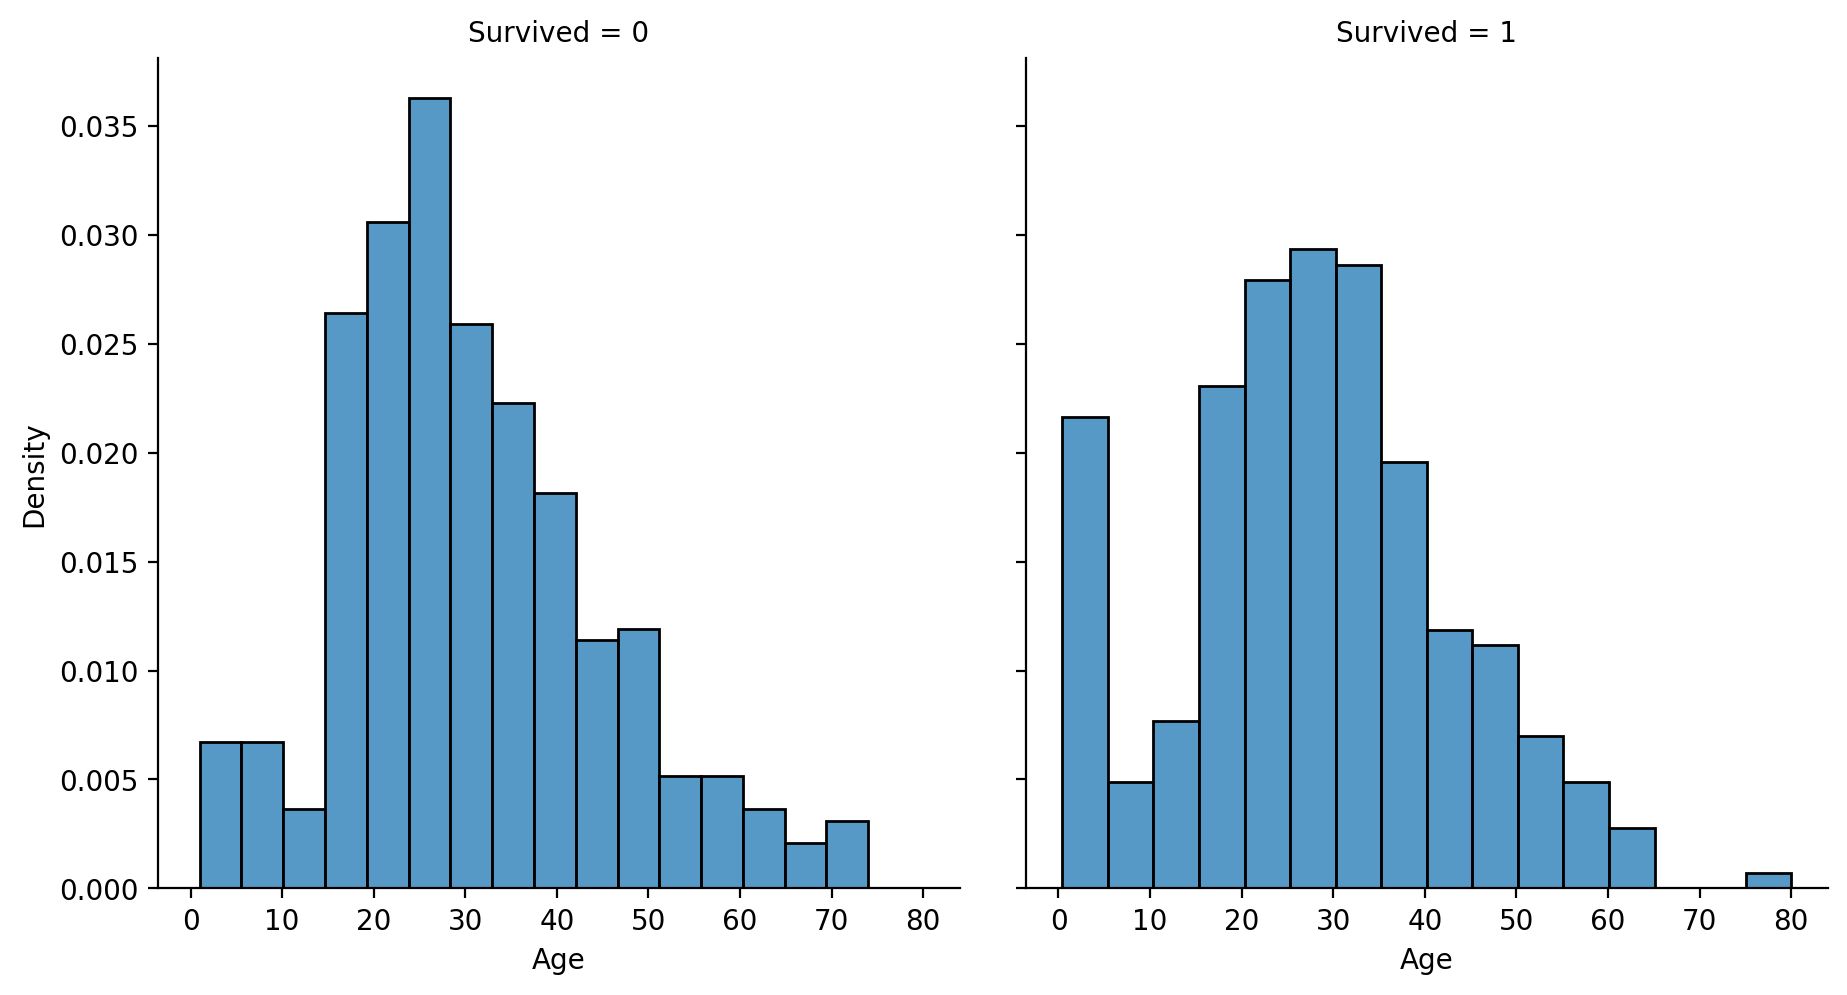

In [167]:
# Age distribution by survival

g = sns.FacetGrid(train, col='Survived')
g.map(sns.histplot, 'Age', stat='density')
g.fig.set_dpi(200)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
plt.show()

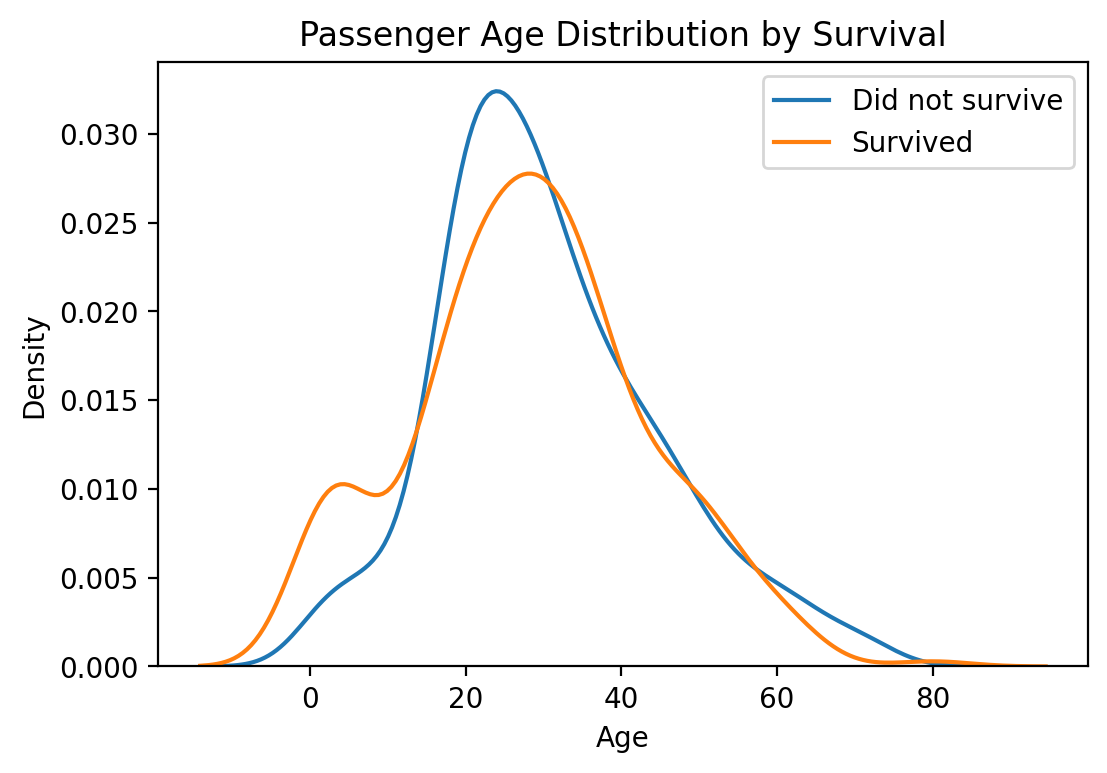

In [166]:
fig = plt.figure(dpi=200)
sns.kdeplot(train['Age'][train['Survived']==0], label='Did not survive')
sns.kdeplot(train['Age'][train['Survived']==1], label='Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')
plt.legend()
plt.show()

From the charts, younger children were more likely to survive than their grandparents.

### Fare Variable

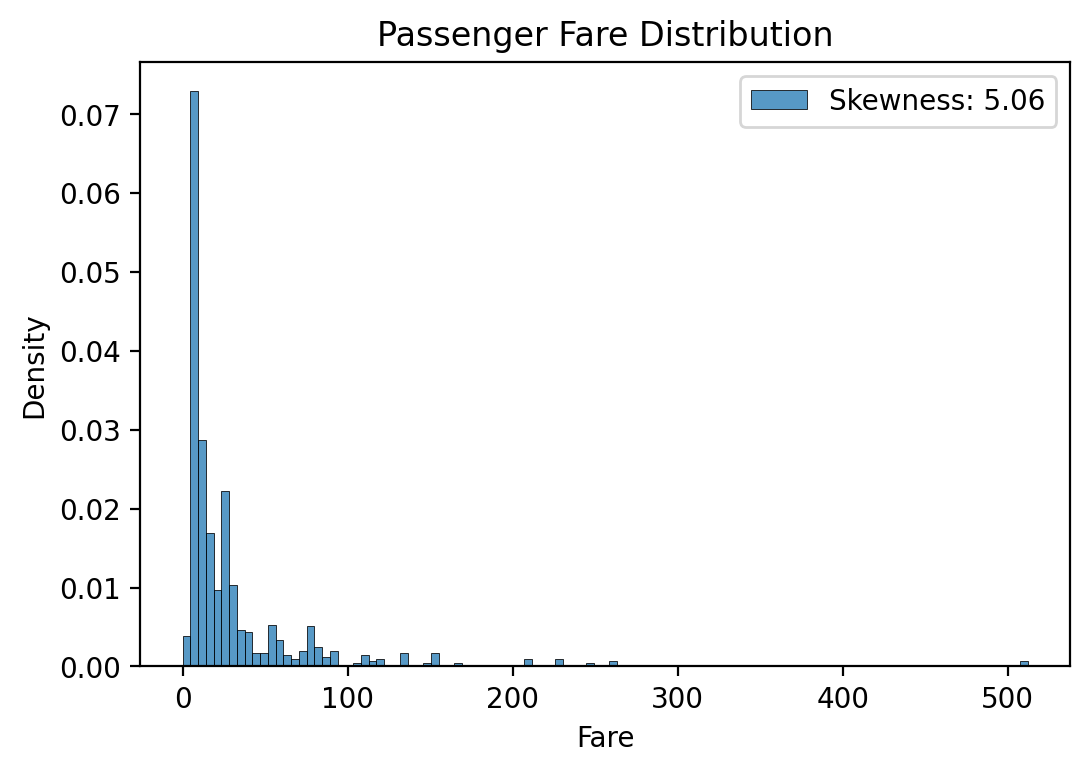

In [174]:
# Passenger fare distribution
fig = plt.figure(dpi=200)
sns.histplot(train['Fare'], stat='density', label='Skewness: %.2f'%(train['Fare'].skew()))
plt.title('Passenger Fare Distribution')
plt.legend()
plt.show()

Skewness can affect model accuracy. We can address this later.

### Summary

1. Women had a higher survival rate over male passengers as they were prioritized during the evacuation.
2. First Class passengers had a higher survival rate than Second and Third class passengers.
3. Younger ages, like children, were also prioritized during the evacuation, causing higher survival rates among that group.

## Data Preprocessing and Modeling

The following preprocessing steps will be performed on the data.

- Drop and fill missing values
- Data transformation (log transformation)
- Feature engineering
- Feature encoding

In [175]:
# For simplicity, we can drop ticket and cabin features from datasets.

train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)

In [177]:
# Check missing values in training set

train.isnull().sum().sort_values(ascending = False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

In [179]:
# Find most frequent value (mode) of Embarked in training set

mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [180]:
# Fill missing values (two of them) in Embarked column with the mode value

train['Embarked'].fillna(mode, inplace=True)

In [183]:
# Find missing values in the test set

test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Embarked        0
dtype: int64

In [182]:
# Compute average Fare in test set

median = test['Fare'].dropna().median()
median

14.4542

In [184]:
# Fill missing Fare value (just the one) in the test set

test['Fare'].fillna(median, inplace=True)

In [185]:
# Combine training and test set

combine = pd.concat([train, test], axis = 0).reset_index(drop=True)
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [186]:
# Find missing values in the combined dataset

combine.isnull().sum().sort_values(ascending=False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

The missing values in Survived are from the test set.

To account for the missing Age values, we can predict estimates by correlating other features.

In [187]:
# Convert set into numerical values where 0 = male and 1 = female

combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

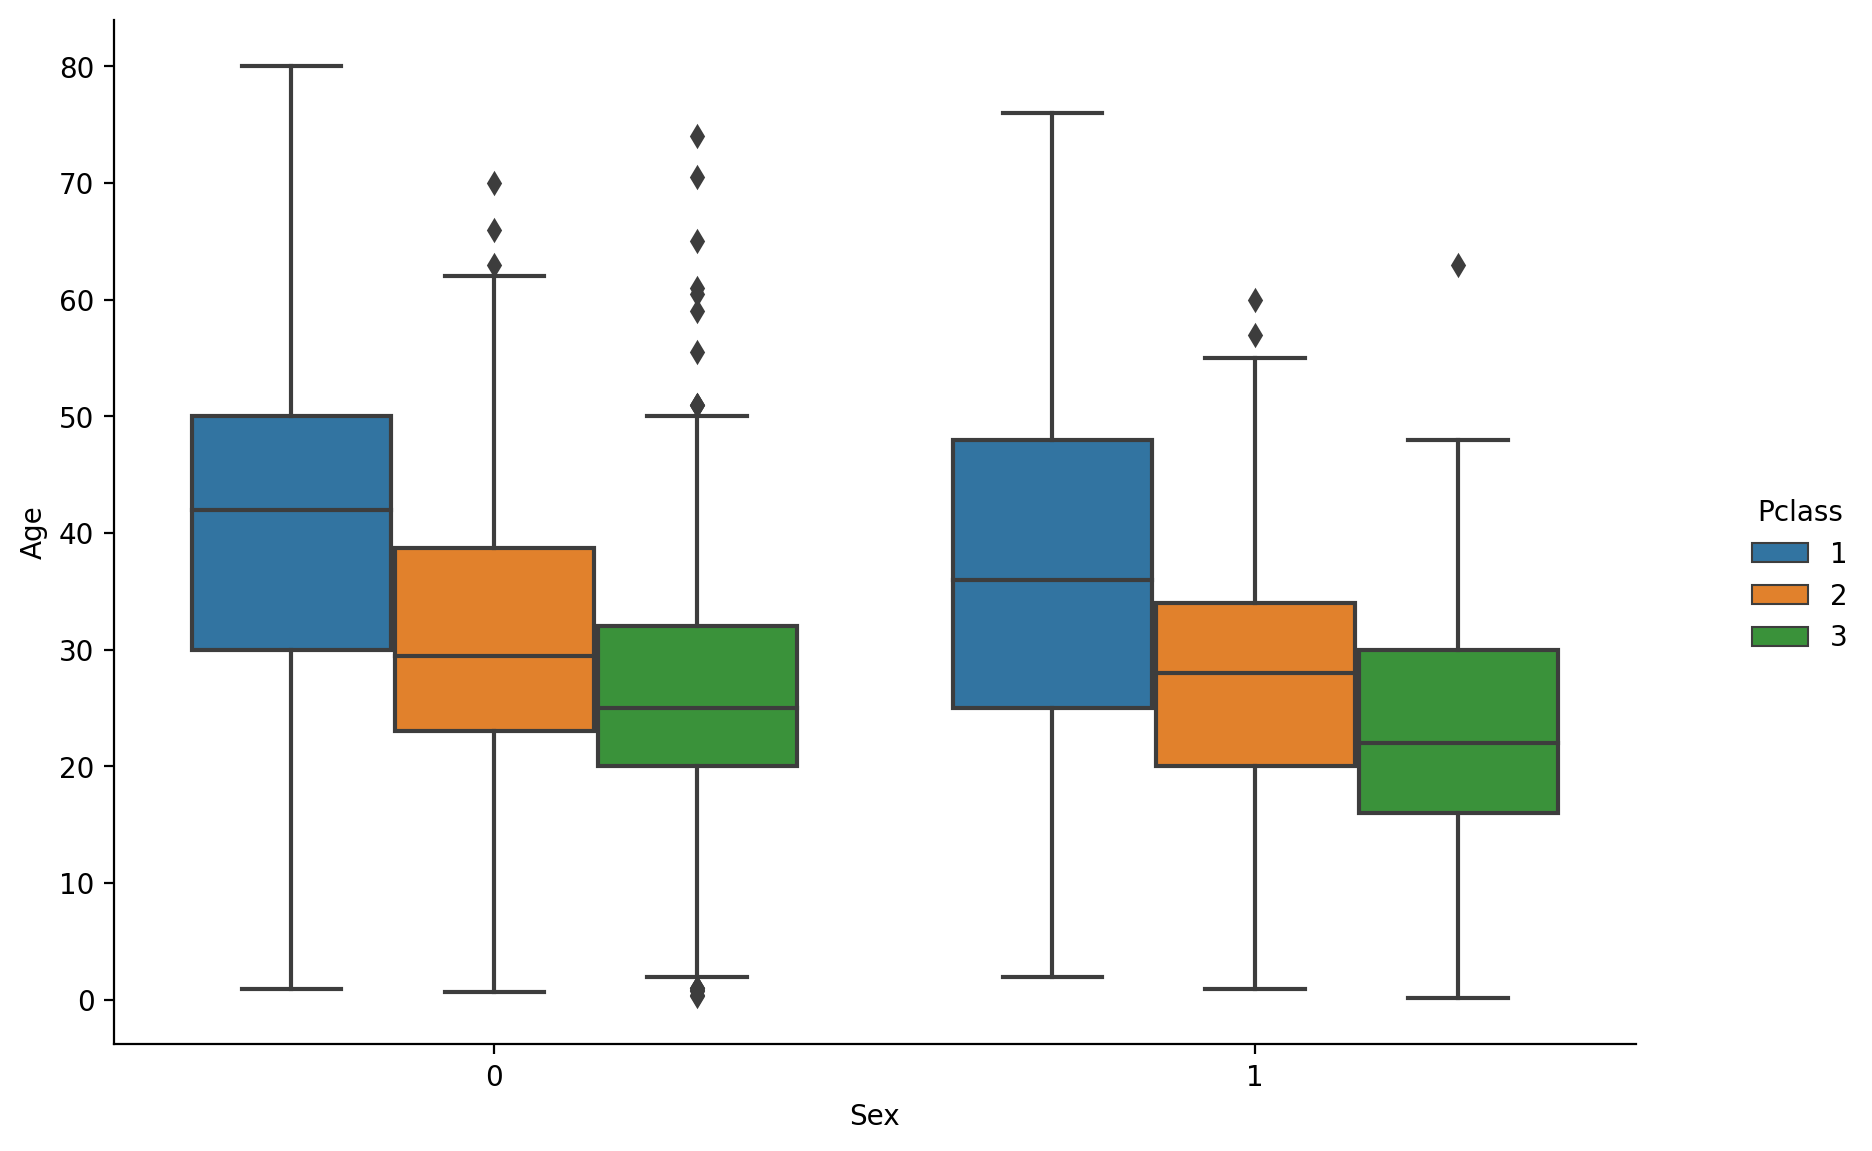

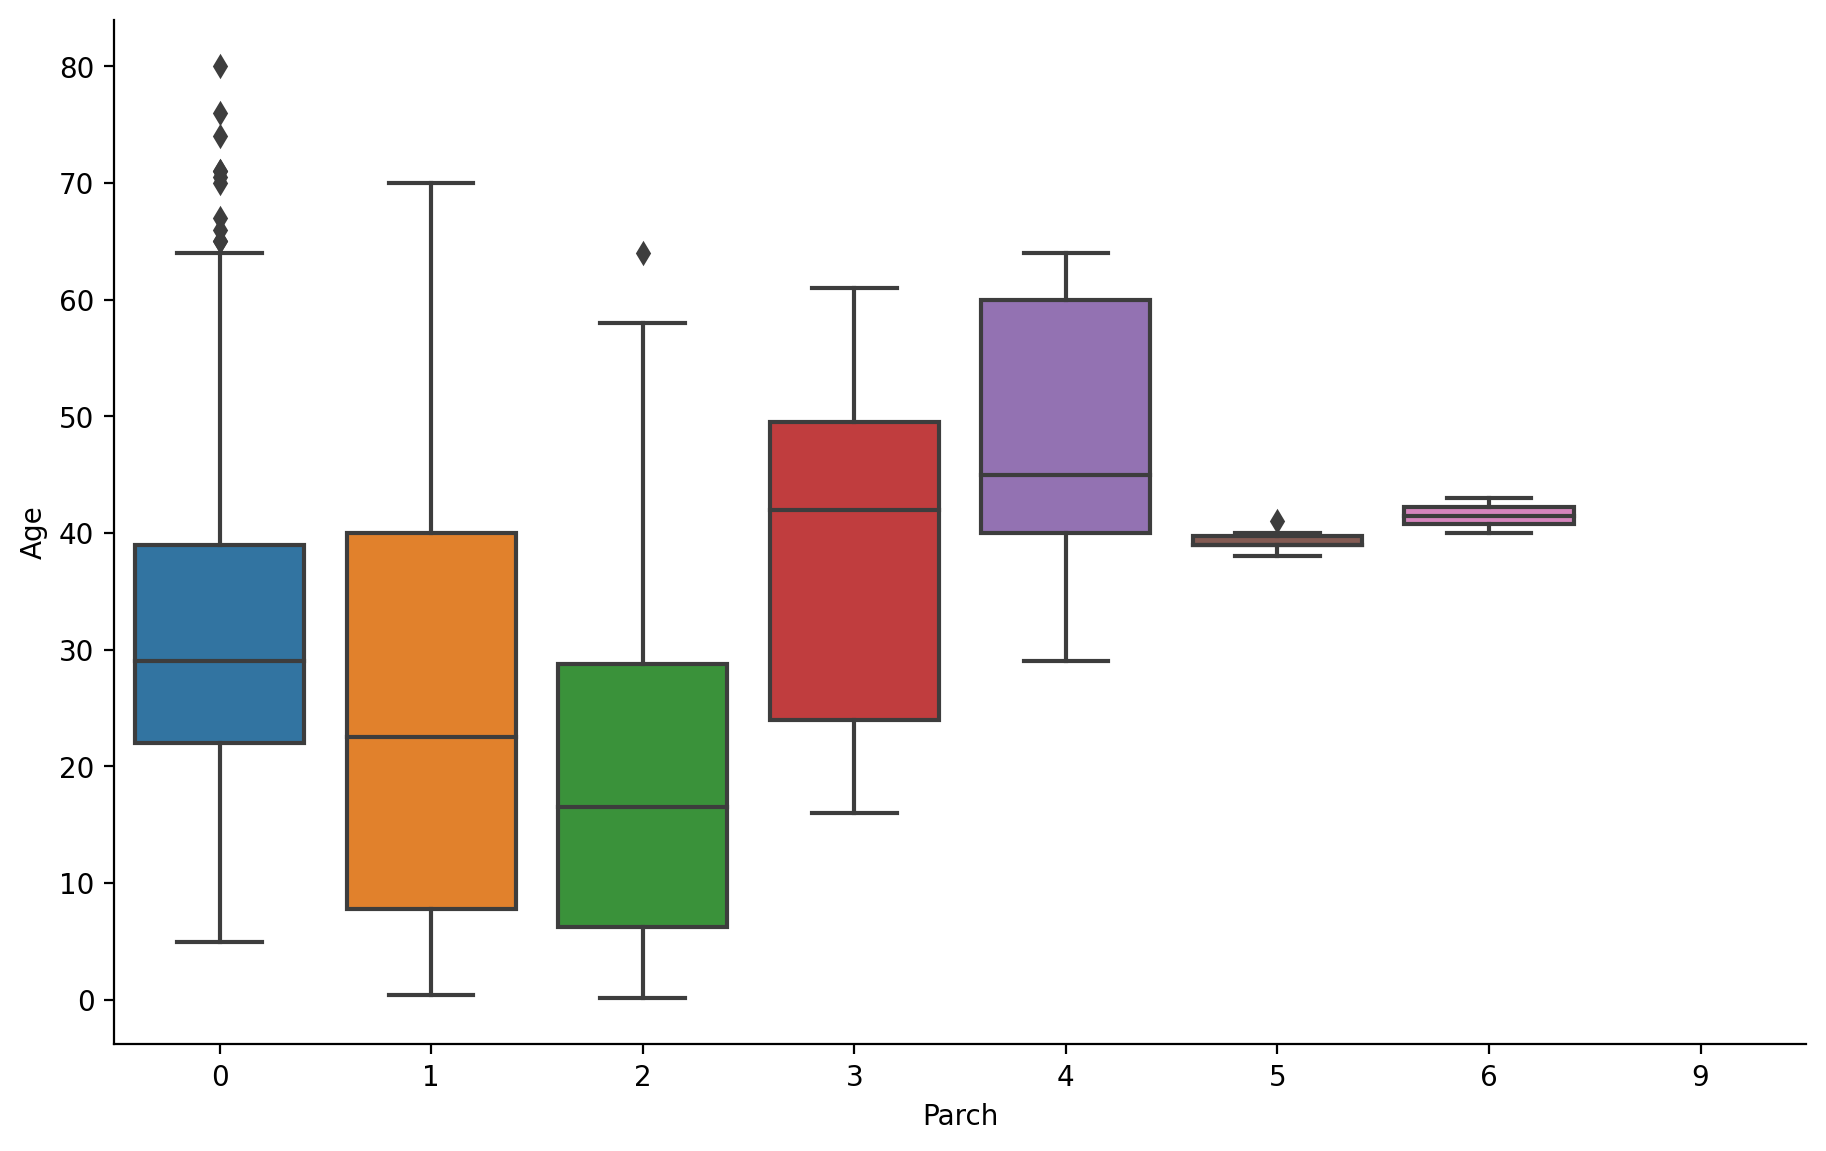

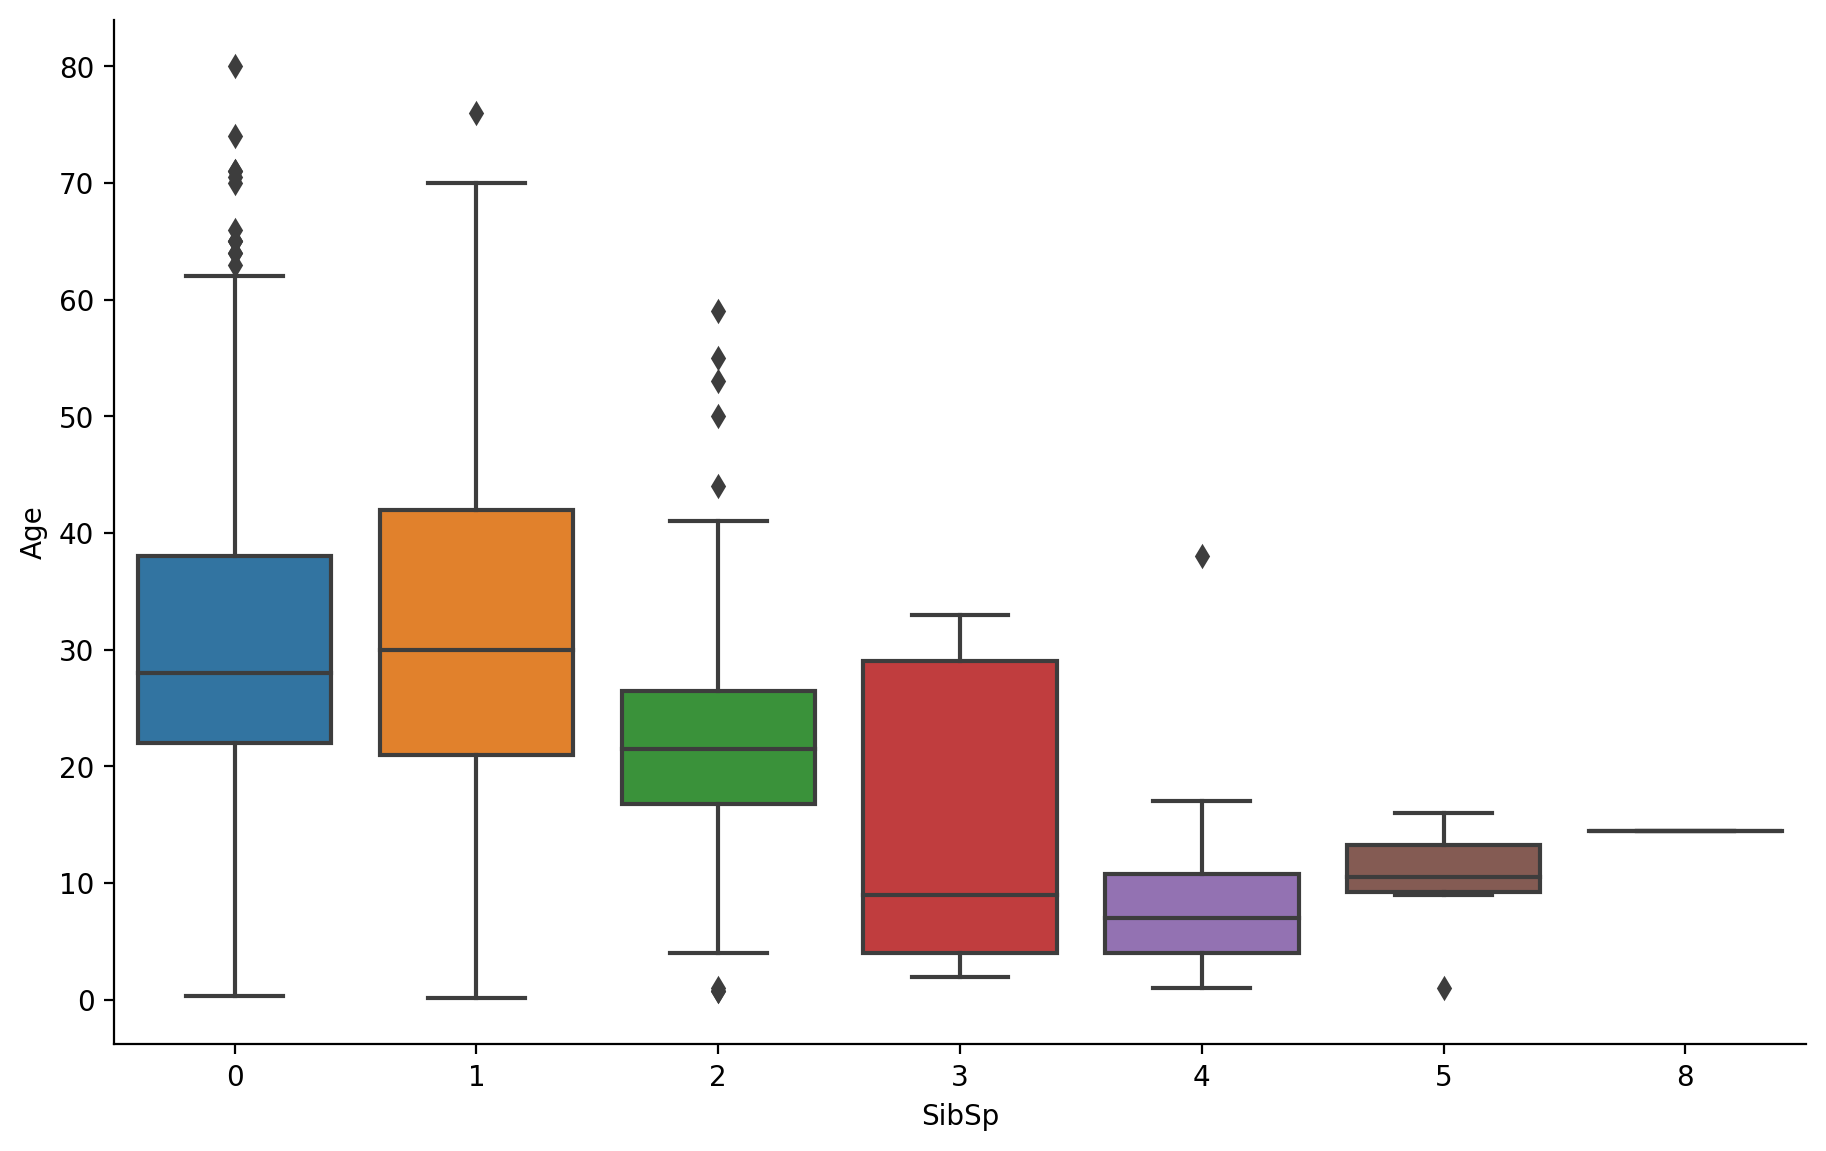

In [195]:
g1 = sns.catplot(y='Age', x='Sex', hue='Pclass', kind='box', data=combine)
g2 = sns.catplot(y='Age', x='Parch', kind='box', data=combine)
g3 = sns.catplot(y='Age', x='SibSp', kind='box', data=combine)
g1.fig.set_dpi(200)
g2.fig.set_dpi(200)
g3.fig.set_dpi(200)
g1.fig.set_figwidth(10)
g1.fig.set_figheight(6)
g2.fig.set_figwidth(10)
g2.fig.set_figheight(6)
g3.fig.set_figwidth(10)
g3.fig.set_figheight(6)
plt.show()

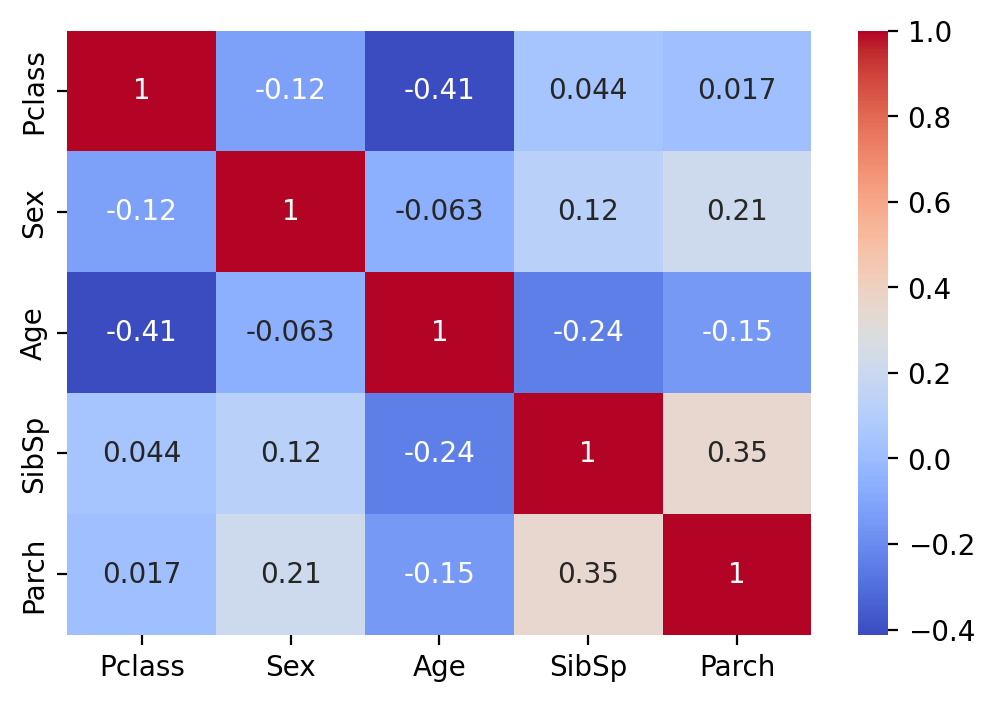

In [197]:
# Plot heatmap of Parch, SibSp, Age, Sex, and Pclass

fig = plt.figure(dpi=200)
sns.heatmap(combine.drop(['Survived', 'Name', 'PassengerId', 'Fare'], axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()

Age looks to be negatively correlated with Pclass, SibSp, and Parch.

In [199]:
# Get indices for missing Age values

age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

We can loop through the indices where age is missing to locate rows that have the same SibSp, Parch and PClass values to fill in missing ages. If no suitable rows are found, we can use the median Age.

In [200]:
median_age = combine['Age'].median()

for index in age_nan_indices:
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp'])
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]['Pclass'])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

/Users/peterpan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [202]:
# The previous generated a warning, but we'll ignore that for now
# Make sure there are no more missing age values

combine['Age'].isnull().sum()

0

### Data Transormation

The passenger Fare values were skewed. We can apply a log transformation to address that

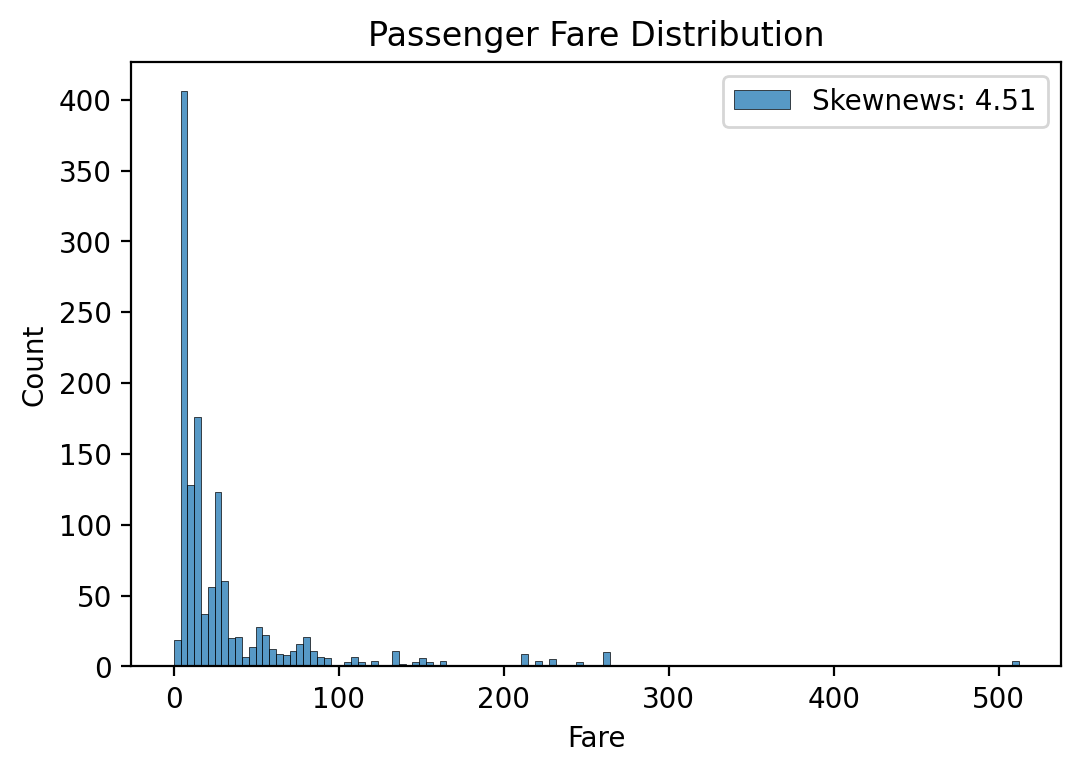

In [204]:
# Passenger fare distribution


fig = plt.figure(dpi=200)
sns.histplot(combine['Fare'], label='Skewnews: %.2f'%(combine['Fare'].skew()))
plt.legend()
plt.title('Passenger Fare Distribution')
plt.show()

In [205]:
# Apply log transformation to Fare column to reduce skewness

combine['Fare'] = combine['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

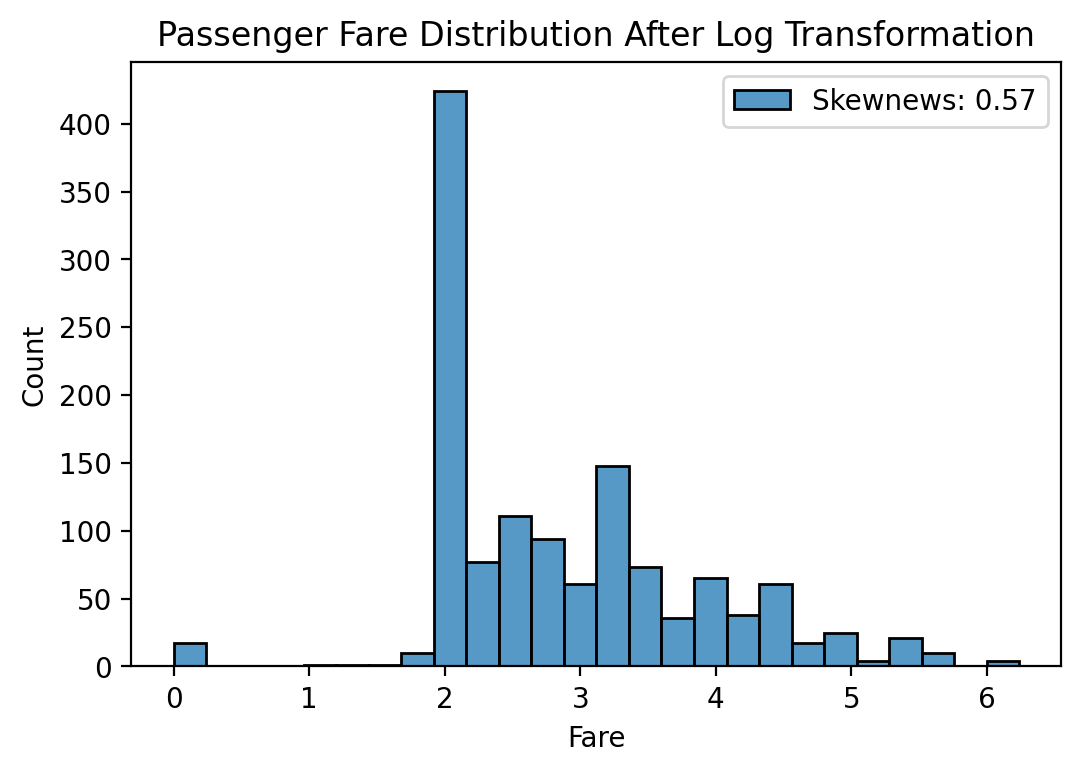

In [206]:
# Passenger fare distribution after log transformation

fig = plt.figure(dpi=200)
sns.histplot(combine['Fare'], label='Skewnews: %.2f'%(combine['Fare'].skew()))
plt.legend()
plt.title('Passenger Fare Distribution After Log Transformation')
plt.show()

### Feature Engineering

We'll look at creating 3 new features that will help us create predictive models with improved accuracy.

- Title
- IsAlone
- Age*Class

In [207]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,1.981001,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,4.266662,C
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,2.070022,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,3.972177,S
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,2.085672,S


In [209]:
# Get person's title from name

combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()   

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [211]:
# Value counts for Title

combine['Title'].value_counts(ascending=False)

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [212]:
# Number of unique Titles

combine['Title'].nunique()

18

In [216]:
# Simplify the Titles

combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Lady',
                                            'Jonkheer', 'Don', 'Capt', 'the Countess',
                                            'Sir', 'Dona'], 'Rare')
combine['Title'] = combine['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine['Title'] = combine['Title'].replace('Mme', 'Mrs')

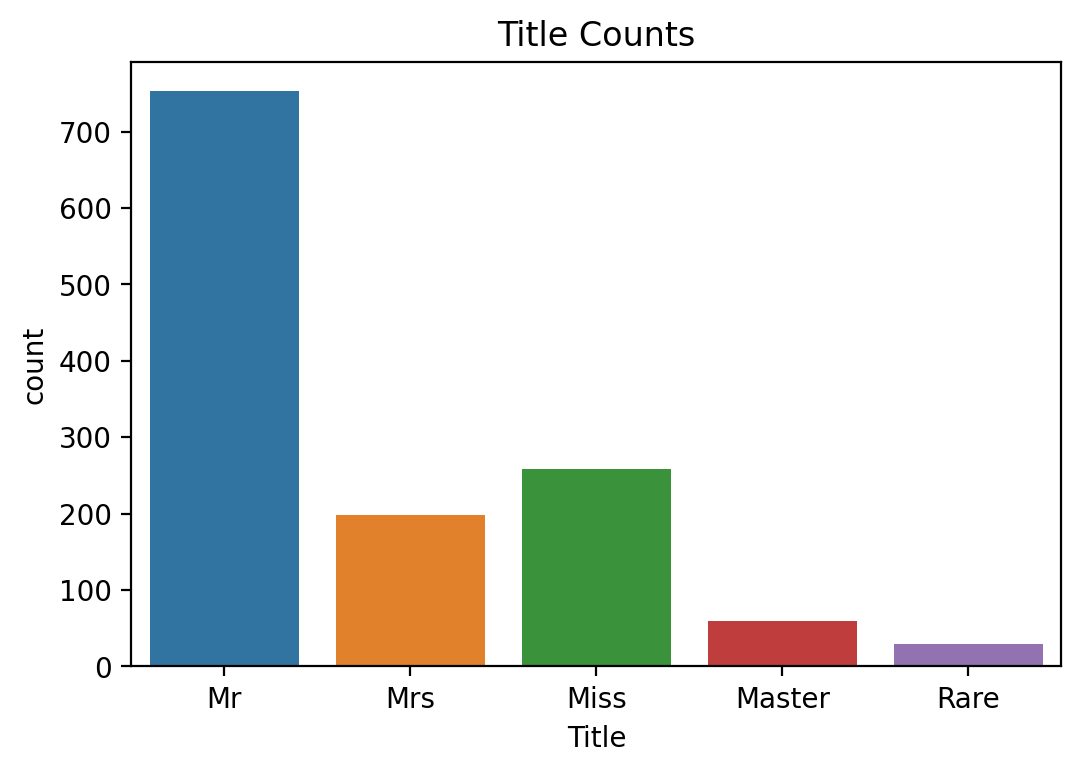

In [217]:
fig = plt.figure(dpi=200)
sns.countplot(x=combine['Title'])
plt.title('Title Counts')
plt.show()

In [219]:
# Average survival rate by name title

combine[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.711111
0,Master,0.589744
4,Rare,0.347826
2,Mr,0.157895


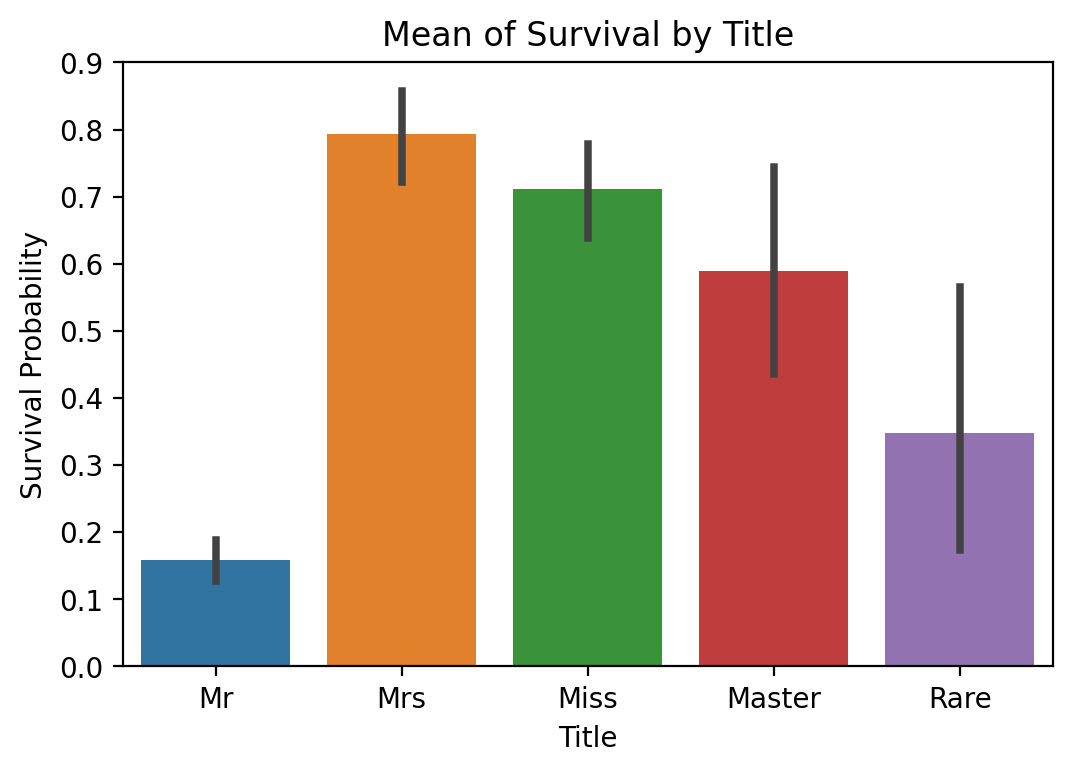

In [225]:
fig = plt.figure(dpi=200)
sns.barplot(x='Title', y='Survived', data=combine)
plt.ylabel('Survival Probability')
plt.title('Mean of Survival by Title')
plt.show()

In [226]:
# We no longer need the name column

combine = combine.drop('Name', axis=1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0.0,3,0,22.0,1,0,1.981001,S,Mr
1,2,1.0,1,1,38.0,1,0,4.266662,C,Mrs
2,3,1.0,3,1,26.0,0,0,2.070022,S,Miss
3,4,1.0,1,1,35.0,1,0,3.972177,S,Mrs
4,5,0.0,3,0,35.0,0,0,2.085672,S,Mr


In [228]:
# IsAlone feature
# Calculate family size from SibSp and Parch

combine['FamilySize'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'FamilySize']].head(10)

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1
5,0,0,1
6,0,0,1
7,3,1,5
8,0,2,3
9,1,0,2


In [229]:
# Average of survival by family size

combine[['FamilySize', 'Survived']].groupby('FamilySize', as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.052632
7,8,0.000000
8,11,NaN


In [230]:
# Create IsAlone feature

combine['IsAlone'] = 0
combine.loc[combine['FamilySize'] == 1, 'IsAlone'] = 1

In [232]:
# Mean of survival by IsAlone
# 0 = not alone, 1 = is alone

combine[['IsAlone', 'Survived']].groupby('IsAlone', as_index=False).mean().sort_values(by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.514535
1,1,0.303538


In [233]:
# We no longer need SibSp, Parch, or FamilySize features

combine = combine.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,1,0.0,3,0,22.0,1.981001,S,Mr,0
1,2,1.0,1,1,38.0,4.266662,C,Mrs,0
2,3,1.0,3,1,26.0,2.070022,S,Miss,1
3,4,1.0,1,1,35.0,3.972177,S,Mrs,0
4,5,0.0,3,0,35.0,2.085672,S,Mr,1


In [235]:
# Create Age*Class

# First, we will seperate Ages into 5 seperate age bands

combine['AgeBand'] = pd.cut(combine['Age'], 5)
combine[['AgeBand', 'Survived']].groupby('AgeBand', as_index=False).mean().sort_values(by='AgeBand')

,AgeBand,Survived
0,"(0.0902, 16.136]",0.532110
1,"(16.136, 32.102]",0.339662
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [237]:
# Assign ordinal values to each age band

combine.loc[combine['Age'] <= 16.136, 'Age'] = 0
combine.loc[(combine['Age'] > 16.136) & (combine['Age'] <= 32.102), 'Age'] = 1
combine.loc[(combine['Age'] > 32.102) & (combine['Age'] <= 48.068), 'Age'] = 2
combine.loc[(combine['Age'] > 48.068) & (combine['Age'] <= 64.034), 'Age'] = 3
combine.loc[combine['Age'] > 64.034, 'Age'] = 4

In [238]:
# We no longer need the AgeBand

combine = combine.drop('AgeBand', axis=1)

In [239]:
# Check Age and Plcass data types

combine[['Age', 'Pclass']].dtypes

Age       float64
Pclass      int64
dtype: object

In [240]:
# Convert ordinal Age into an integer

combine['Age'] = combine['Age'].astype('int')
combine[['Age', 'Pclass']].dtypes

Age       int64
Pclass    int64
dtype: object

In [241]:
# Create Age*Class feature

combine['Age*Class'] = combine['Age'] * combine['Pclass']
combine[['Age', 'Pclass', 'Age*Class']].head()

,Age,Pclass,Age*Class
0,1,3,3
1,2,1,2
2,1,3,3
3,2,1,2
4,2,3,6


In [242]:
# Feature Encoding
# - machine learning models need numerical values to process.
# - So, we'll need to encode categorical data appropriately

combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Mrs,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Mrs,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [244]:
# Encode Title and Embarked features
# - pandas get_dummies() converts categorical data into indicator variables

combine = pd.get_dummies(combine, columns=['Title'])
combine = pd.get_dummies(combine, columns=['Embarked'], prefix='Em')
combine.head()

KeyError: "None of [Index(['Title'], dtype='object')] are in the [columns]"

In [245]:
# Divide Fare into four bands

combine['FareBand'] = pd.cut(combine['Fare'], 4)
combine[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.517007
3,"(4.679, 6.239]",0.750000


In [246]:
# Assign ordinal to each fare band

combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [247]:
# Convert Fare into an integer

combine['Fare'] = combine['Fare'].astype('int')

In [248]:
# We no longer need the FareBand feature

combine = combine.drop('FareBand', axis=1)

In [249]:
combine.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [250]:
# Seperate training and test data into their own

train = combine[:len(train)]
test = combine[len(train):]

In [251]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [252]:
# Get rid of the passenger ID column

train = train.drop('PassengerId', axis=1)
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [254]:
# Convert survived back to integer in the training set

train['Survived'] = train['Survived'].astype('int')
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [255]:
# Now the test set

test.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Em_C,Em_Q,Em_S
881,892,NaN,3,0,2,1,1,6,0,0,1,0,0,0,1,0
882,893,NaN,3,1,2,1,0,6,0,0,0,1,0,0,0,1
883,894,NaN,2,0,3,1,1,6,0,0,1,0,0,0,1,0
884,895,NaN,3,0,1,1,1,3,0,0,1,0,0,0,0,1
885,896,NaN,3,1,1,1,0,3,0,0,0,1,0,0,0,1


In [257]:
# Get rid of passenger Survived column since that's our target value

test = test.drop('Survived', axis=1)
test.head()

KeyError: "['Survived'] not found in axis"

## Modeling

For machine learning models, we will test out the following classifiers for the work.

- Logistic regression
- Support vector machines
- K-nearest neighbors
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest
- CatBoost

In [258]:
# Split training data

X_train = train.drop('Survived', axis=1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis=1).copy()
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (881, 14)
Y_train shape: (881,)
X_test shape: (418, 14)


In [259]:
# Logistic Regression
# - Requires 3 steps:
# - 1. instantiate the model
# - 2. fit the model to the training set
# - 3. predict the data in the test set

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.93

In [262]:
# Support vector machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.09

In [265]:
# K-nearest neighbors (KNN)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.79

In [267]:
# Gaussian naive bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.11

In [275]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.57

In [269]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/Users/peterpan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


80.25

In [276]:
# Stochastic gradient descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

79.23

In [278]:
# Decision tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

85.7

In [279]:
# Random forest

random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.58

In [285]:
# CatBoost

catboost = CatBoostClassifier(verbose=False)
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)
acc_catboost

85.7

In [286]:
# Model evaluation
# - What model has the highest accuracy?

models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Decision Tree,85.70
1,CatBoost,85.70
2,Random Forest,85.58
3,KNN,84.79
4,Support Vector Machines,83.09
5,Logistic Regression,80.93
6,Linear SVC,80.25
7,Perceptron,79.57
8,Stochastic Gradient Decent,79.23
9,Naive Bayes,79.11


In [296]:
# CatBoost looks good, let's go with that

catboost = CatBoostClassifier(verbose=False)
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)
acc_catboost

85.7

In [297]:
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [298]:
len(Y_pred)

418

### Preparing data for submission

In [301]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [303]:
gender_submission.shape

(418, 2)

The submission data should have 418 rows and 2 columns: PassengerId and Survived.

In [305]:
# Create submission DataFrame

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
881,892,0
882,893,0
883,894,0
884,895,0
885,896,1


In [306]:
submit.shape

(418, 2)

In [307]:
submit.to_csv('svm_titanic.csv', index=False)